# Quixo
---
<p align="center">
<img style="float:center" src="../images/quixo.jpg" alt="drawing" width="300" height="300"/>
</p>

In [1]:
import pickle
import math
import matplotlib.pyplot as plt
from random import randint, random, choice
from game import Move, Player
from CustomGameClass import Quixo as Game
from tqdm import trange
from typing import Literal
import numpy as np

## Reinforcement Learning Player
---

This class represents a player that uses Reinforcement Learning to make decisions in Quixo.

Attributes:
- ``epochs`` (int): The number of training epochs.
- ``alpha`` (float): The learning rate.
- ``discount_factor`` (float): The discount factor of the Bellman equation.
- ``min_exploration_rate`` (float): The minimum exploration rate during training.
- ``exploration_decay_rate`` (float): The rate at which the exploration rate decays during training.
- ``opponent`` (Player): The opponent player.
- ``states`` (list): A list to store the states visited during a game.
- ``state_value`` (dict): A dictionary to store the value of each state.
- ``training_phase`` (bool): A boolean to indicate if the player is training or not. It basically enables the exploration if it is true, otherwise it uses only the `state_value` dictionary to make decisions.

Methods:
- ``give_rew(reward)``: Placeholder method for giving reward to the player.
- ``add_state(state)``: Adds to the ``states`` array the state that a player has seen during a game.
- ``reset()``: Reset the ``states`` array to be able to start a new game.
- ``make_move(game)``: Chooses an action to take based on the current game state that can be random or based on the value of the dictionary. It takes from the dictionary, for each possible move, the value associated with the state of the board with the move performed. The maximum value will be the move to execute. We use the following recursive (bellman equation) formula to compute the state-value table: 
$$
V(S_t) \leftarrow V(S_t) + \alpha * (\gamma * V(S_t +1) - V(S_t))
$$
- ``update_state_value_table(reward)``: Updates the values of the ``states_value`` dictionary based on the states that the player has seen during the game and the reward that they have provided.
- ``game_reward(player)``: Calculates the reward for the player in the current game.
- ``train()``: Trains the player using reinforcement learning.
- ``save_policy(name)``: Saves the state value table to a file.
- ``load_policy(file)``: Loads the state value table from a file.

In [2]:
class RLPlayer(Player):
    def __init__(self, epochs: int,
                 alpha: float,
                 discount_factor: float,
                 min_exploration_rate: float,
                 exploration_decay_rate: float,
                 opponent: 'Player',
                 training_phase: bool) -> None:
        
        super().__init__()
        self.epochs = epochs
        self.alpha = alpha
        self.discount_factor = discount_factor
        self.exploration_rate = 1
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        self.opponent = opponent
        self.training_phase = training_phase
        self.states=[]
        self.state_value = {}
    
    def give_rew(self, reward):
        pass
    
    def add_state(self, state):
        self.states.append(state)
        
    def reset(self):
        self.states = []
    
    def make_move(self, game: Game) -> tuple[tuple[int, int], Move]:
        available_moves = get_possible_moves(game, game.get_current_player())
        if self.training_phase and (random() < self.exploration_rate):  # do exploration
            return choice(available_moves)
        else:  # do exploitation
            value_max = -999
            for move in available_moves:
                tmp = game.get_board()
                game._Quixo__move(move[0], move[1], game.get_current_player())
                next_status = convert_matrix_board_to_tuple(game.get_board())
                game.set_board(tmp)
                value = 0 if self.state_value.get(next_status) is None else self.state_value.get(next_status)
                if value > value_max:
                    value_max = value
                    action = move
        return action
        
    def update_state_value_table(self, reward):
        for st in reversed(self.states):
            if self.state_value.get(st) is None:
                self.state_value[st] = 0
            current_q_value = self.state_value[st]
            reward = current_q_value + self.alpha * (self.discount_factor * reward - current_q_value)
            self.state_value[st] = reward
        
    def game_reward(self, player: 'RLPlayer')-> Literal[-10, 0, 10]:
        if self == player:
            return 10
        else:
            return -10
    
    def train(self, player_name='') -> None:
        
        all_rewards = []
        # define how many episodes to run
        pbar = trange(self.epochs)
        # define the players
        players = (self, self.opponent)
        
        for epochs in pbar:
            game = Game()
            rewards = 0
            winner = -1
            players = (players[1], players[0])
            player_idx = 1
            
            while winner < 0:
                # change player
                player_idx = (player_idx + 1) % 2
                player = players[player_idx]
                game.switch_player()
                
                ok = False
                if self == player:
                    while not ok:
                        from_pos, slide = self.make_move(game)
                        ok = game._Quixo__move(from_pos, slide, game.get_current_player())
                        state_after_move = convert_matrix_board_to_tuple(game.get_board())
                        self.add_state(state_after_move)
                        
                else:
                    while not ok:
                        from_pos, slide = player.make_move(game)
                        ok = game._Quixo__move(from_pos, slide, game.get_current_player())
                winner = game.check_winner()
            
            # update the exploration rate
            self.exploration_rate = np.clip(
                np.exp(-self.exploration_decay_rate * epochs), self.min_exploration_rate, 1
            )
            
            reward = self.game_reward(player)
            self.update_state_value_table(reward)
            rewards += reward
            self.reset()
            all_rewards.append(rewards)
            pbar.set_description(f'rewards value: {rewards}, current exploration rate: {self.exploration_rate:2f}')
        
        plot_training_trends(all_rewards, filename=f"{player_name} trained against {self.opponent.__class__.__name__}")
        
        print(f'** Last 50_000 episodes - Mean rewards value: {sum(all_rewards[-50_000:]) / 50_000:.2f} **')

    def save_policy(self, name):
        fw = open(name, 'wb')
        pickle.dump(self.state_value, fw)
        fw.close()

    def load_policy(self, file):
        fr = open(file, 'rb')
        self.state_value = pickle.load(fr)
        fr.close()

## MinMax Player
---

This class represents a player who uses the MinMax algorithm to make decisions in the game. The MinMax algorithm is a search algorithm that is used in two-player games to make optimal decisions.

Attributes:
- ``playerPlaying`` (int): The player who is currently playing.
- ``levels_depth`` (list): A list of tuples, where each tuple contains the depth level and the maximum number of possible moves for that depth level.

Methods:
- ``game_evaluation``: Evaluate the game state based on the current player and depth. If player X wins, the reward is 1, otherwise it is -1. If player O plays instead, the rewards are reversed.
- ``min_max``: Perform the Minimax algorithm to determine the best move for the current player. This method takes as input the current game, the alpha and beta values (used for alpha-beta pruning, a technique for reducing the number of nodes evaluated by the MinMax algorithm), and the current depth of the search tree. If the depth is zero or if there is a winner in the game, the method returns the game rating and no moves. Otherwise, for each possible move, it creates a copy of the game, makes the move, and recursively calls the min_max method on the copy of the game. If the returned rating is greater than alpha, alpha is updated and the move is considered the best move. If beta is less than or equal to alpha, the cycle stops for alpha-beta pruning.
The process is similar for the case where the current player is non-zero, with the difference that we try to minimize the rating instead of maximizing it.
- ``choose_action``: Choose the best action (move) for the current player using the Minimax algorithm. The method starts by getting all possible moves for the current player using the `get_possible_moves` function. It then calculates the search depth for the MinMax algorithm based on the number of possible moves. This is done through a for loop that passes through the `levels_Depth` list. If the number of possible moves is greater than a certain value, the depth is set to a certain level. The cycle stops as soon as a level is found that does not exceed the number of possible moves. The method then calls the `min_max` method to determine the best move for the current player. Finally, the method returns the best move.

In [3]:
class MinMaxPlayer(Player):
    def __init__(self, playerPlaying, levels_depth):
        super().__init__()
        self.moves_value = []
        self.playerPlaying = playerPlaying
        self.levels_depth = levels_depth

    def game_evaluation(self, game: Game, depth):
        win = game.check_winner()
        ret = 0 + depth
        if win == 0 and self.playerPlaying == 0:
            ret = 100 + depth
        elif win == 0 and self.playerPlaying == 1:
            ret = -100 - depth
        elif win == 1 and self.playerPlaying == 1:
            ret = 100 + depth
        elif win == 1 and self.playerPlaying == 0:
            ret = - 100 - depth
        return ret

    def min_max(self, game: 'Game', alpha, beta, depth):
        if depth <= 0 or game.check_winner() != -1:
            return self.game_evaluation(game, depth), None
        best_move = None
        if game.current_player == self.playerPlaying:
            for move in get_possible_moves(game, game.get_current_player()):
                tmp = game.get_board()
                g = Game()
                g.set_board(tmp)
                g.current_player = self.playerPlaying
                g._Quixo__move(move[0], move[1], g.get_current_player())
                g.current_player = 1 - self.playerPlaying
                eval, _ = self.min_max(g, alpha, beta, depth - 1)
                if eval > alpha:
                    alpha = eval
                    best_move = move
                if beta <= alpha:
                    break
            return alpha, best_move
        else:
            for move in get_possible_moves(game, game.get_current_player()):
                tmp = game.get_board()
                g = Game()
                g.set_board(tmp)
                g.current_player = 1 - self.playerPlaying
                g._Quixo__move(move[0], move[1], g.get_current_player())
                g.current_player = self.playerPlaying
                eval, _ = self.min_max(g, alpha, beta, depth - 1)
                if eval < beta:
                    beta = eval
                    best_move = move
                if beta <= alpha:
                    break
            return beta, best_move

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        possibleMoves = get_possible_moves(game, game.get_current_player())
        possibleMoveCount = len(possibleMoves)

        depth = 0
        for depthLvl in self.levels_depth:
            if possibleMoveCount > depthLvl[1]:
                depth = depthLvl[0]
            else:
                break

        _, move = self.min_max(game, -math.inf, math.inf, depth)

        return move

    def give_rew(self, reward):
        pass

## Utility functions
---

- ``convert_matrix_to_tuple``: Convert the matrix board representation to a tuple representation.
- ``get_possible_moves``: Returns a list of possible moves for the player. It returns a list of tuples, where each tuple contains the move coordinates and the move direction. Each move is a tuple of the form (row, column, direction). The direction is a string that can be either 'up', 'down', 'left' or 'right'.
- `test_player`: Test the performance of a player against another player. The method takes as input the two players, the number of games to play, and the name of the two players just to specify them in the plot. The method prints the number of wins for the first player and the number of wins for the second player.
- ``plot_total_win_rate``: Creates a bar graph to display the total number of wins of two players in a game. The generated image is saved in the ``images`` folder.
- ``plot_training_trends``: Creates a graph to visualize the trend of total rewards while training a reinforcement learning agent. Within the function, the average of the rewards is calculated every 500 training steps. The generated image is saved in the ``images`` folder.

In [4]:
def convert_matrix_board_to_tuple(board):
    """
    Converts a matrix board to a tuple representation.

    Args:
        board (list): The matrix board to be converted.

    Returns:
        tuple: The converted tuple representation of the board.
    """
    current_board = tuple(tuple(riga) for riga in board)
    return current_board

def get_possible_moves(game: 'Game', player: int) -> list[tuple[tuple[int, int], Move]]:
    """
    Get a list of possible moves for a given player in the game.

    Args:
        game (Game): The game object representing the current state of the game.
        player (int): The player for whom to find the possible moves.

    Returns:
        list[tuple[tuple[int, int], Move]]: A list of tuples, where each tuple contains the coordinates of a possible move
        and the corresponding move direction.

    """
    # possible moves:
    # - take border empty and fill the hole by moving in the 3 directions
    # - take one of your blocks on the border and fill the hole by moving in the 3 directions
    # 44 at start possible moves
    pos = set()
    for r in [0, 4]:
        for c in range(5):
            if game.get_board()[r, c] == -1 or game.get_board()[r, c] == player:
                if r == 0 and c == 0:  # OK
                    pos.add(((c, r), Move.BOTTOM))
                    pos.add(((c, r), Move.RIGHT))
                elif r == 0 and c == 4:  # OK
                    pos.add(((c, r), Move.BOTTOM))
                    pos.add(((c, r), Move.LEFT))
                elif r == 4 and c == 0:  # OK
                    pos.add(((c, r), Move.TOP))
                    pos.add(((c, r), Move.RIGHT))
                elif r == 4 and c == 4:  # OK
                    pos.add(((c, r), Move.TOP))
                    pos.add(((c, r), Move.LEFT))
                elif r == 0:  # OK
                    pos.add(((c, r), Move.BOTTOM))
                    pos.add(((c, r), Move.LEFT))
                    pos.add(((c, r), Move.RIGHT))
                elif r == 4:  # OK
                    pos.add(((c, r), Move.TOP))
                    pos.add(((c, r), Move.LEFT))
                    pos.add(((c, r), Move.RIGHT))
    for c in [0, 4]:
        for r in range(5):
            if game.get_board()[r, c] == -1 or game.get_board()[r, c] == player:
                if r == 0 and c == 0:  # OK
                    pos.add(((c, r), Move.BOTTOM))
                    pos.add(((c, r), Move.RIGHT))
                elif r == 0 and c == 4:  # OK
                    pos.add(((c, r), Move.BOTTOM))
                    pos.add(((c, r), Move.LEFT))
                elif r == 4 and c == 0:  # OK
                    pos.add(((c, r), Move.TOP))
                    pos.add(((c, r), Move.RIGHT))
                elif r == 4 and c == 4:  # OK
                    pos.add(((c, r), Move.TOP))
                    pos.add(((c, r), Move.LEFT))
                elif c == 0:
                    pos.add(((c, r), Move.TOP))
                    pos.add(((c, r), Move.RIGHT))
                    pos.add(((c, r), Move.BOTTOM))
                elif c == 4:
                    pos.add(((c, r), Move.TOP))
                    pos.add(((c, r), Move.LEFT))
                    pos.add(((c, r), Move.BOTTOM))
    return list(pos)

def test_player(player1, player2, num_games, name_player1, name_player2):
    """
    Test the performance of two players in a series of games.

    Parameters:
    player1 (object): The first player object.
    player2 (object): The second player object.
    num_games (int): The number of games to be played.
    name_player1 (str): The name of the first player.
    name_player2 (str): The name of the second player.

    Returns:
    None
    """
    g = Game()
    player1_wins = 0
    player2_wins = 0
    draws = 0
    games = 0
    for _ in range(num_games):
        winner = g.play(player1, player2)
        games += 1
        g.reset()
        if winner == 0:
            player1_wins += 1
        if winner == 1:
            player2_wins += 1
        if winner == -1:
            draws += 1
    
    plot_total_win_rate(player1_wins, player2_wins, draws, name_player1, name_player2)
    print(f"{name_player1} won {player1_wins / num_games * 100}%")
    print(f"{name_player2} won {player2_wins / num_games * 100}%")
    print(f"Draws: {draws / num_games * 100}%")

def plot_total_win_rate(wins_player1, wins_player2, draws, name_player1, name_player2):
    """
    Plots the total win rate of two players.

    Parameters:
    - wins_player1 (int): Number of wins for player 1.
    - wins_player2 (int): Number of wins for player 2.
    - draws (int): Number of draws.
    - name_player1 (str): Name of player 1.
    - name_player2 (str): Name of player 2.

    Returns:
    None
    """
    plt.bar([name_player1, name_player2, 'draws'], [wins_player1, wins_player2, draws], color=['blue', 'orange', 'green'])
    plt.ylabel('Number of games')
    plt.savefig(f"images/{name_player1} wins vs {name_player2} wins.png")
    plt.show()

def plot_training_trends(total_rewards: [int], filename=''):
    """
    Plots the training trends of the total rewards.

    Args:
        total_rewards (list[int]): List of total rewards obtained during training.
        filename (str, optional): Name of the file to save the plot. Defaults to ''.
    """
    mean_array = np.mean(np.array(total_rewards).reshape(-1, 500), axis=1)
    index = np.arange(0, len(total_rewards), 500)
    plt.plot(index, mean_array, label='Mean rewards value')
    plt.ylabel('Mean rewards value')
    plt.xlabel('Index')
    plt.savefig(f"images/{filename} training_trends.png")
    plt.show()

## Random Player Definition
---

In [5]:
class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        from_pos = (randint(0, 4), randint(0, 4))
        move = choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])
        return from_pos, move

    def give_rew(self, reward):
        pass

    def add_state(self, s):
        pass

## Human Player Definition
---

In [6]:
class HumanPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
            available_moves = get_possible_moves(game, game.get_current_player())
            while True:
                row = int(input("Input your action row:"))
                col = int(input("Input your action col:"))
                from_pos = (row, col)
                move = int(input("Input your action move: (1 for top, 2 for bottom, 3 for left, 4 for right):"))
                if move == 1:
                    move = Move.TOP
                elif move == 2:
                    move = Move.BOTTOM
                elif move == 3:
                    move = Move.LEFT
                elif move == 4:
                    move = Move.RIGHT
                else:
                    print("Invalid move, please input again")
                    continue
                
                if (from_pos, move) in available_moves:
                    return from_pos, move
                else:
                    print("Invalid move, please input again")
                    continue

    def give_rew(self, reward):
        pass

    def add_state(self, s):
        pass

## Hyperparameters
---
- ``epochs``: training epochs
- ``alpha``: learning rate
- ``discount_factor``: the discount rate of the Bellman equation
- ``min_exploration_rate``: the minimum rate for exploration during the training phase
- ``exploration_decay_rate``: the exploration decay rate used during the training
- ``training_phase``: a boolean value that indicates if the player is in training phase or not. It basically enables the exploration if it is true, otherwise it uses only the `state_value` dictionary to make decisions.
- ``RandomP``: the opponent to play against that use a Random strategy for the RL training
- ``MinMaxP``: the opponent to play against that use a MinMax strategy for the RL testing. It takes as input the `level_depth`, a list of tuples, where each tuple contains the depth level and the maximum number of possible moves for that depth level. For example if there are 5 possible moves, the depth level is 4, if there are 40 possible moves, the depth level is 1.
- ``num_games``: number of games for testing

In [7]:
epochs = 5
alpha = 0.1
discount_factor = 0.95
min_exploration_rate=0.01
exploration_decay_rate=5e-6
training_phase=True
RandomP = RandomPlayer()
MinMaxP = MinMaxPlayer(0, [(4,0),(3,23),(2,28),(1,32)])
num_games = 1

## Let's do some computation: RL Player trained against Random Player

In [ ]:
# create the RL player
rl_agent_RandomOpponent = RLPlayer(
    epochs=epochs,
    alpha=alpha,
    discount_factor=discount_factor,
    min_exploration_rate=min_exploration_rate,
    exploration_decay_rate=exploration_decay_rate,
    opponent=RandomP,
    training_phase=training_phase
)
# train the RL player
rl_agent_RandomOpponent.train(player_name='RL_Player_1')

## Test Reinforcement Learning Player vs Random Player

In [ ]:
rl_player = RLPlayer(
    epochs=epochs,
    alpha=alpha,
    discount_factor=discount_factor,
    min_exploration_rate=min_exploration_rate,
    exploration_decay_rate=exploration_decay_rate,
    opponent=RandomP,
    training_phase=False
)

rl_player.load_policy('RL_player_2')

In [ ]:
test_player(rl_player, RandomP, num_games, 'RL_player_1(first_move)', 'Random Player')
test_player(RandomP, rl_player, num_games, 'Random Player', 'RL_player_1(second_move)')

### RL Player results

- RL Player 1
  - ``epochs`` = 500000,
  - ``alpha`` = 0.1,
  - ``discount_factor`` = 0.95,
  - ``min_exploration_rate`` = 0.01,
  - ``exploration_decay_rate`` = 1e-5,
   
  **Results**
  - Last 50000 episodes - Mean rewards value: 6.44
  - win rate vs ``RandomPlayer`` in 1000 games (RL always first move) - 90%
  -  win rate vs ``RandomPlayer`` in 1000 games (Random always first move) - 74%
  
- RL Player 2
  - ``epochs`` = 750000,
  - ``alpha`` = 0.1,
  - ``discount_factor`` = 0.95,
  - ``min_exploration_rate`` = 0.01,
  - ``exploration_decay_rate`` = 5e-6,
   
  **Results**
  - Last 50000 episodes - Mean rewards value: 6.16
  - win rate vs ``RandomPlayer`` in 1000 games (RL always first move) - 88%
  -  win rate vs ``RandomPlayer`` in 1000 games (Random always first move) - 63%

RL Player 1 is the best policy we obtained, and we saved it in ``RL_player_1``. We will use it for the next tests.

## Test MinMax Player vs Random Player

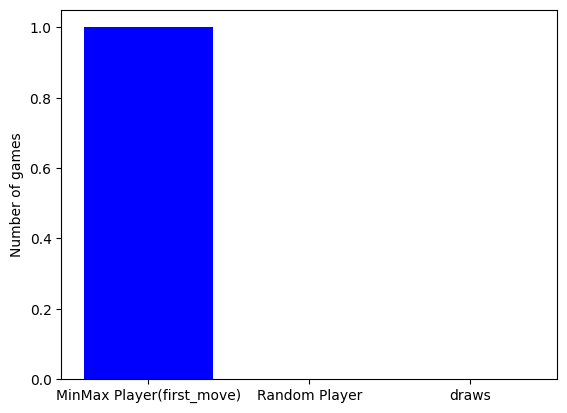

MinMax Player(first_move) won 100.0%
Random Player won 0.0%
Draws: 0.0%


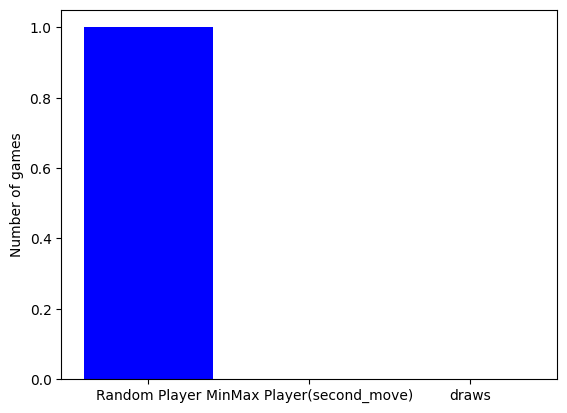

Random Player won 100.0%
MinMax Player(second_move) won 0.0%
Draws: 0.0%


In [10]:
MinMaxP = MinMaxPlayer(0, [(4,0),(3,23),(2,28),(1,32)])
test_player(MinMaxP, RandomP, num_games, 'MinMax Player(first_move)', 'Random Player')
MinMaxP = MinMaxPlayer(1, [(4,0),(3,23),(2,28),(1,32)])
test_player(RandomP, MinMaxP, num_games, 'Random Player', 'MinMax Player(second_move)')

## Test MinMax Player vs RL Player

In [ ]:
# TODO non ha molto senso secondo me metterli a confronto perchè succedono sempre le stesse cose quindi il risultato dipende da come è andata l'exploration nel reinforcement learning 

test_player(MinMaxP, rl_player, num_games, 'MinMax Player(first_move)', 'RL Player')
test_player(rl_player, MinMaxP, num_games, 'RL Player(first_move)', 'MinMax Player')

## Results and conclusions
---

We consider a game as a draw if it lasts more than 200 moves (100 moves for player). This is because the game can last forever. In fact, if the two players play optimally, the game will never end.

### Reinforcement Learning training trends
<div class="container">
    <img src="images/RL_Player_2 trained against RandomPlayer training_trends.png">
    <img src="images/RL_Player_1 trained against RandomPlayer training_trends.png">
</div>

### Reinforcement Learning (RL_player_1) vs Random Player
<div class="container">
    <img src="images/RL_player_1(first_move) wins vs Random Player wins.png">
    <img src="images/Random Player wins vs RL_player_1(second_move) wins.png">
</div>

### Reinforcement Learning (RL_player_2) vs Random Player
<div class="container">
    <img src="images/RL_player_2(first_move) wins vs Random Player wins.png">
    <img src="images/Random Player wins vs RL_player_2(second_move) wins.png">
</div>

### MinMax Player vs Random Player

<div class="container">
    <img src="images/MinMax Player(first_move) wins vs Random Player wins.png">
    <img src="images/Random Player wins vs MinMax Player(second_move) wins.png">
</div>

### MinMax Player vs Reinforcement Learning Player (RL_player_1)

<div class="container">
    <img src="images/MinMax Player(first_move) wins vs RL Player wins.png">
    <img src="images/RL Player(first_move) wins vs MinMax Player wins.png">
</div>



## Let's play!

In [ ]:
# TODO risolvere problema stampa board, non so perché la stampa avviene dopo la richiesta della mossa

rl_player = RLPlayer(
    epochs=epochs,
    alpha=alpha,
    discount_factor=discount_factor,
    min_exploration_rate=min_exploration_rate,
    exploration_decay_rate=exploration_decay_rate,
    opponent=RandomP,
    training_phase=False
)
human_player = HumanPlayer()

rl_player.load_policy('RL_player')
g = Game()
winner = g.play(rl_player, human_player, print_flag=True)